#  Прогнозирование заказов такси <a id="title"></a>

**Цель исследования**:

1. Проанализировать данные о заказах такси в аэропортах.
2. Разработать модель, прогнозирующую количество заказов такси на следующий час.


**Ход исследования**:

Основные данные получаем из файла: ```taxi.csv```. Он содержит исторические данные о заказах такси в аэропортах. 

Описание данных:
+ ```datetime``` — период наблюдения
+ ```num_orders``` — количество заказов за период

Мы проведем анализ временного ряда, изучим тренд и сезонность.
После чего подготовим выборку для обучения моделей - добавим признаки и разделим выборку на train и test. Обучим две модели - линейную регрессию и бустинг. Для бустинга подберем гиперпараметры.
Затем проанализируем результаты моделей на тестовой выборке.
Наконец, проверим модели на адекватность.

Таким образом, исследование пройдет в 6 этапов
1. Загрузка данных
2. Анализ временного ряда
3. Подготовка обучающей выборки
4. Обучение моделей
5. Тестирование моделей
6. Написание общего вывода

## Подготовка

### Импорт библиотек и объявление констант

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.1
RMSE_THRESHOLD = 48

### Загрузка данных

In [4]:
data = pd.read_csv('./datasets/taxi.csv', index_col = 'datetime', parse_dates = True)

Посмотрим на первые строки датафрейма.

In [5]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Выведем общую информацию о датафрейме.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Имеем данные о заказах такси в виде временного ряда с интервалом в 10 минут. В датафрейме два столбца - ```datetime```, который мы сделали индексом временного ряда в процессе чтения из csv, и ```num_orders``` - количество заказов, целочисленный целевой признак.

## Анализ

Проведем анализ временного ряда.

Для начала проверим, что даты и время в индексе расположены в хронологическом порядке.

In [7]:
data.index.is_monotonic_increasing

True

Всё ОК, даты и время в индексе расположены в порядке возрастания.

Посмотрим на значения в индексе и целевом столбце.

In [9]:
data.index.to_series().describe()

count                  26496
mean     2018-05-31 23:55:00
min      2018-03-01 00:00:00
25%      2018-04-15 23:57:30
50%      2018-05-31 23:55:00
75%      2018-07-16 23:52:30
max      2018-08-31 23:50:00
Name: datetime, dtype: object

У нас данные за полгода - с 1 марта 2018 по 31 августа 2018 включительно. 

In [10]:
data['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Среднее число заказов за 10 минут - 14. Минимальное - 0, максимальное - 119.

Проведем ресемплирование по одному часу.

In [11]:
data = data.resample('1H').sum()

Выведем графики количества заказов, скользящего среднего и скользящего стандартного отклонения.

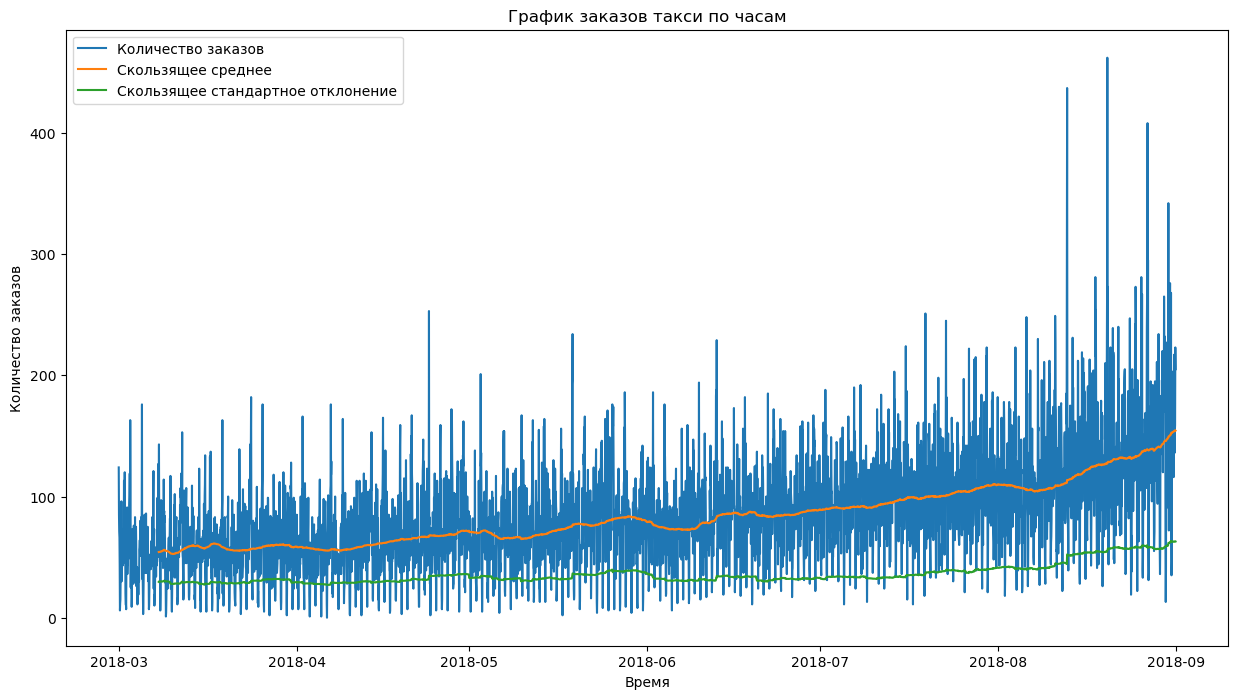

In [12]:
plt.figure(figsize = (15,8))
plt.plot(data['num_orders'], label='Количество заказов')
plt.plot(data['num_orders'].rolling(168).mean(), label='Скользящее среднее')
plt.plot(data['num_orders'].rolling(168).std(), label='Скользящее стандартное отклонение')
plt.legend(title='', loc='upper left')
plt.title('График заказов такси по часам')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Видим увеличение среднего значения со временем, ряд нестационарный.

Разложим временной ряд на составляющие и выведем их графики


In [13]:
decomposed = seasonal_decompose(data)

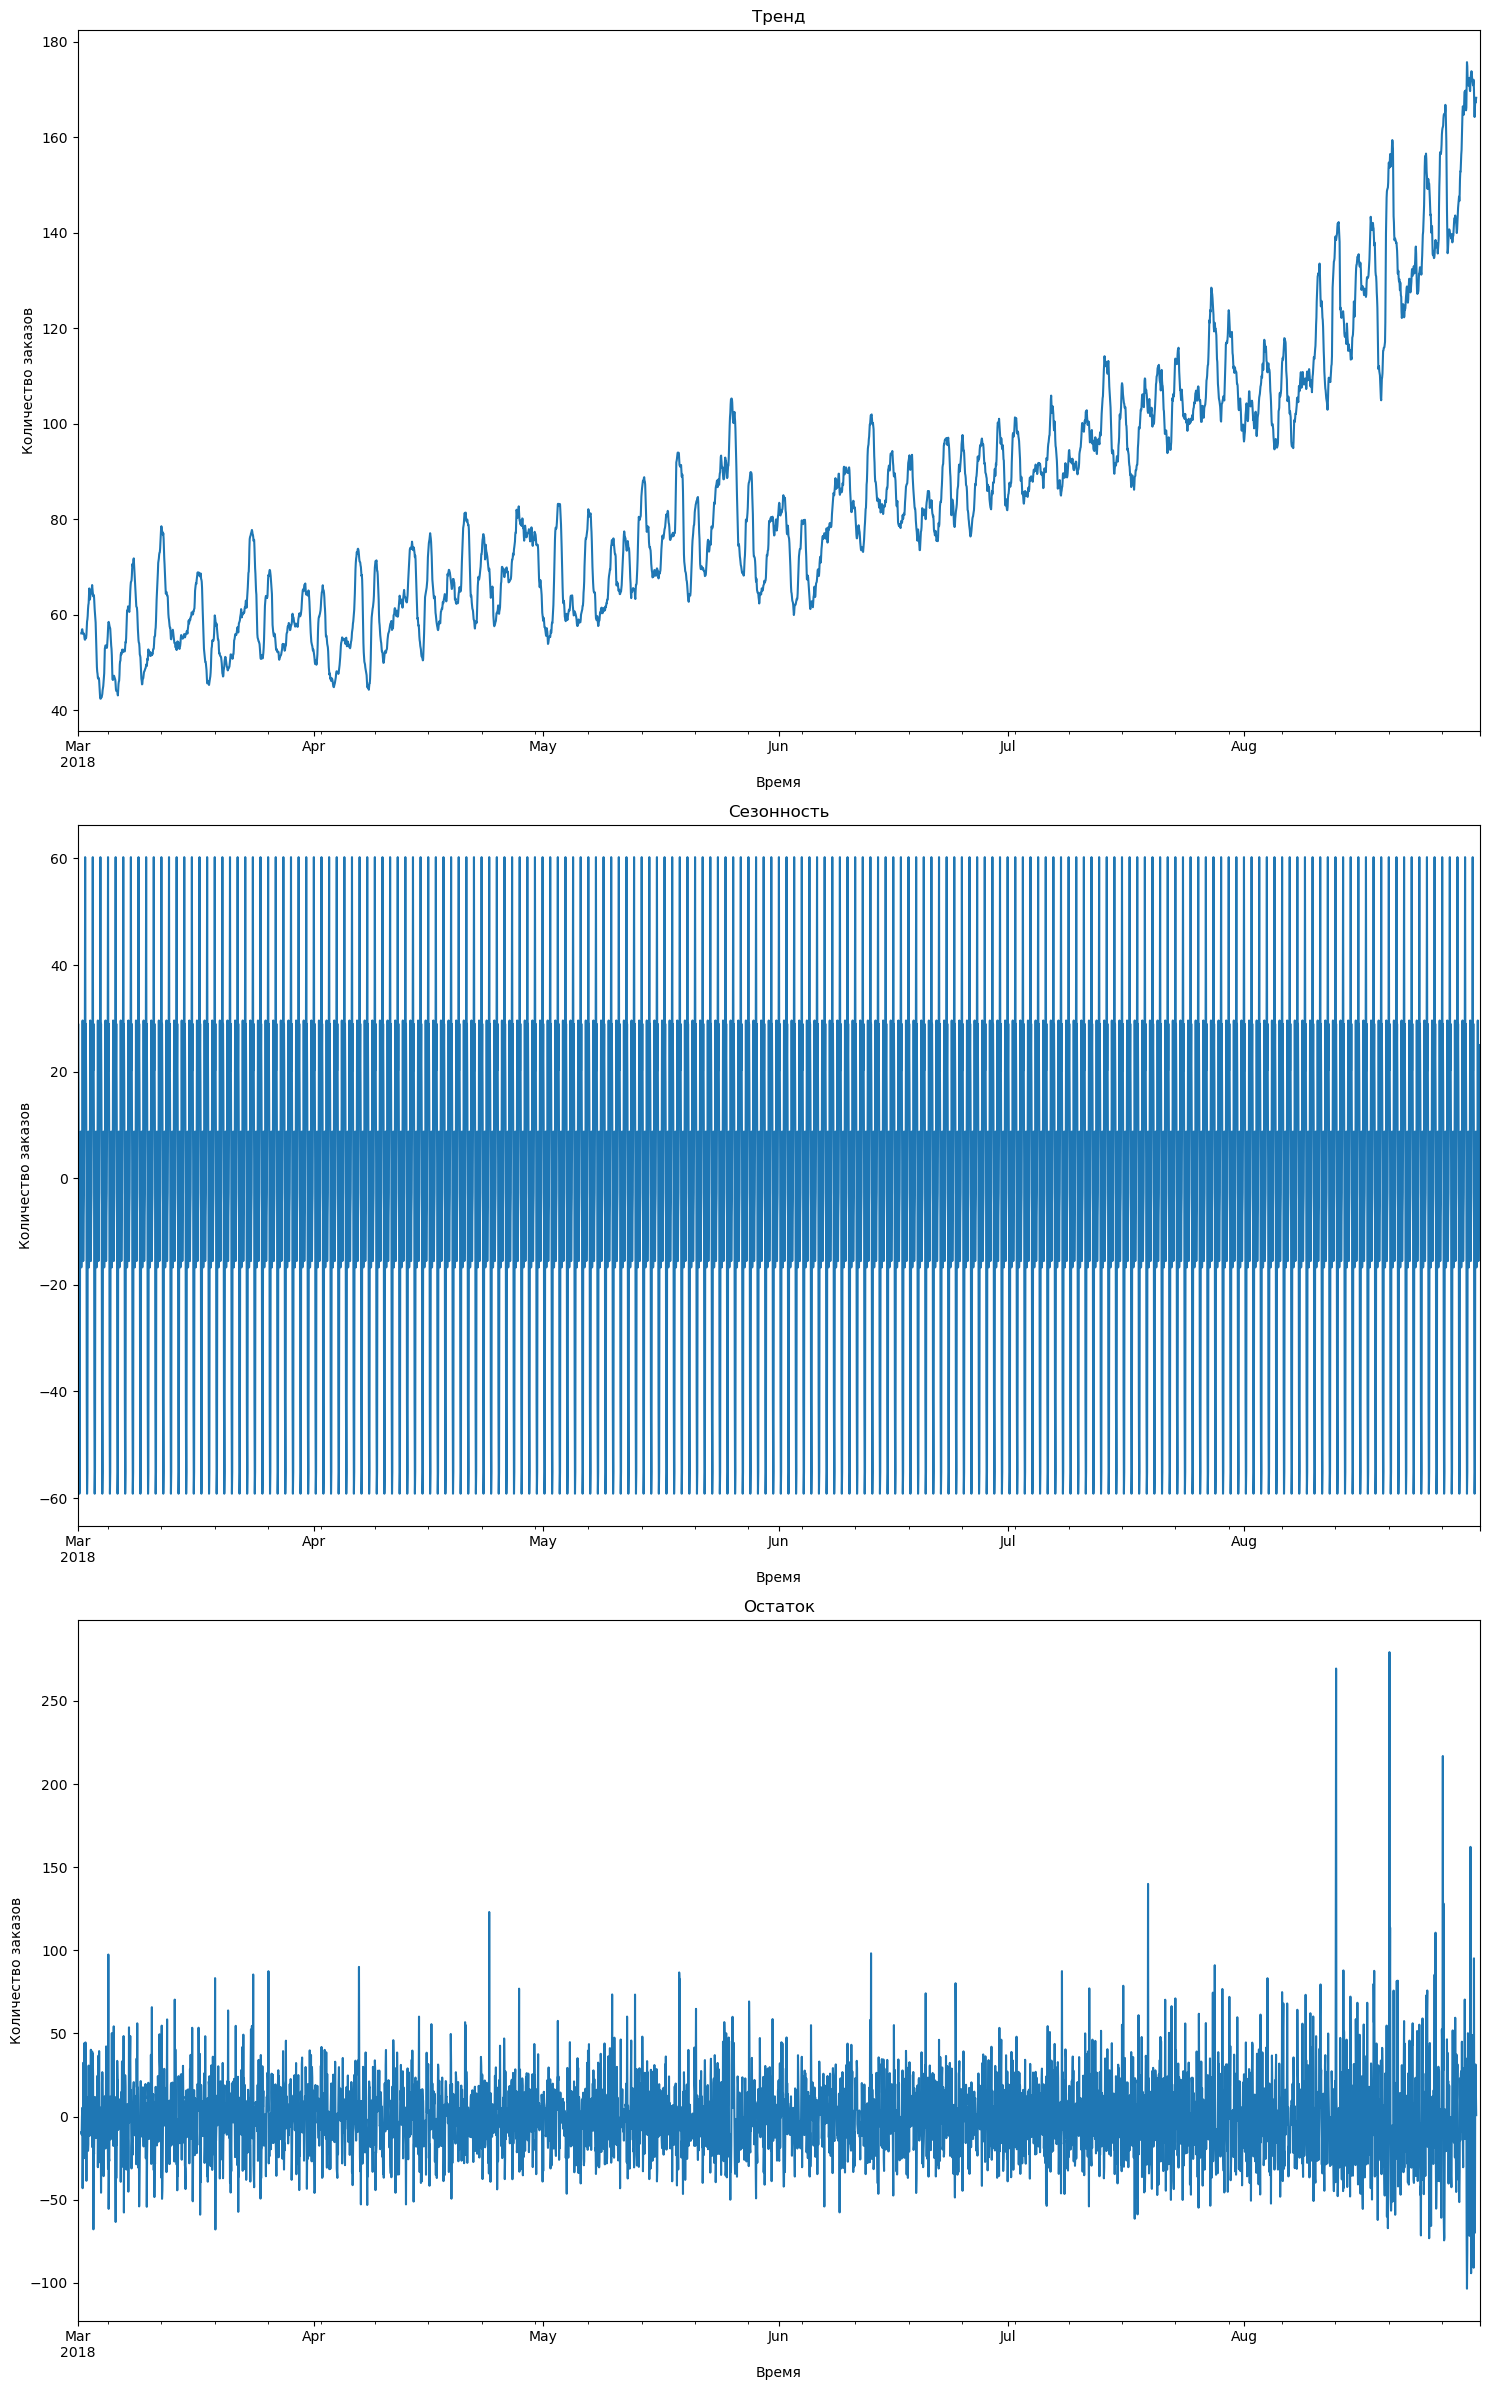

In [14]:
plt.figure(figsize=(15,24))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.tight_layout()

Видим общий тренд увеличения числа заказов. Возможно, это тренд на увеличение популярности такси в целом, а возможно - сезонность, т.к. наибольшее количество заказов наблюдаем в августе, на пике сезона отпусков. Но т.к. данные у нас только за полгода, мы не можем сделать вывод о сезонности такого уровня, только о тренде.

Также видим некоторую сезонность меньшего масштаба - по неделям или по дням. Далее рассмотрим ее подробнее.

Остатки значительно увеличиваются, начиная с августа.

Сделаем ресеплинг по дням, чтобы уменьшить шум на графиках.

In [15]:
data_daily = data.resample('1D').sum()

In [16]:
decomposed_daily = seasonal_decompose(data_daily)

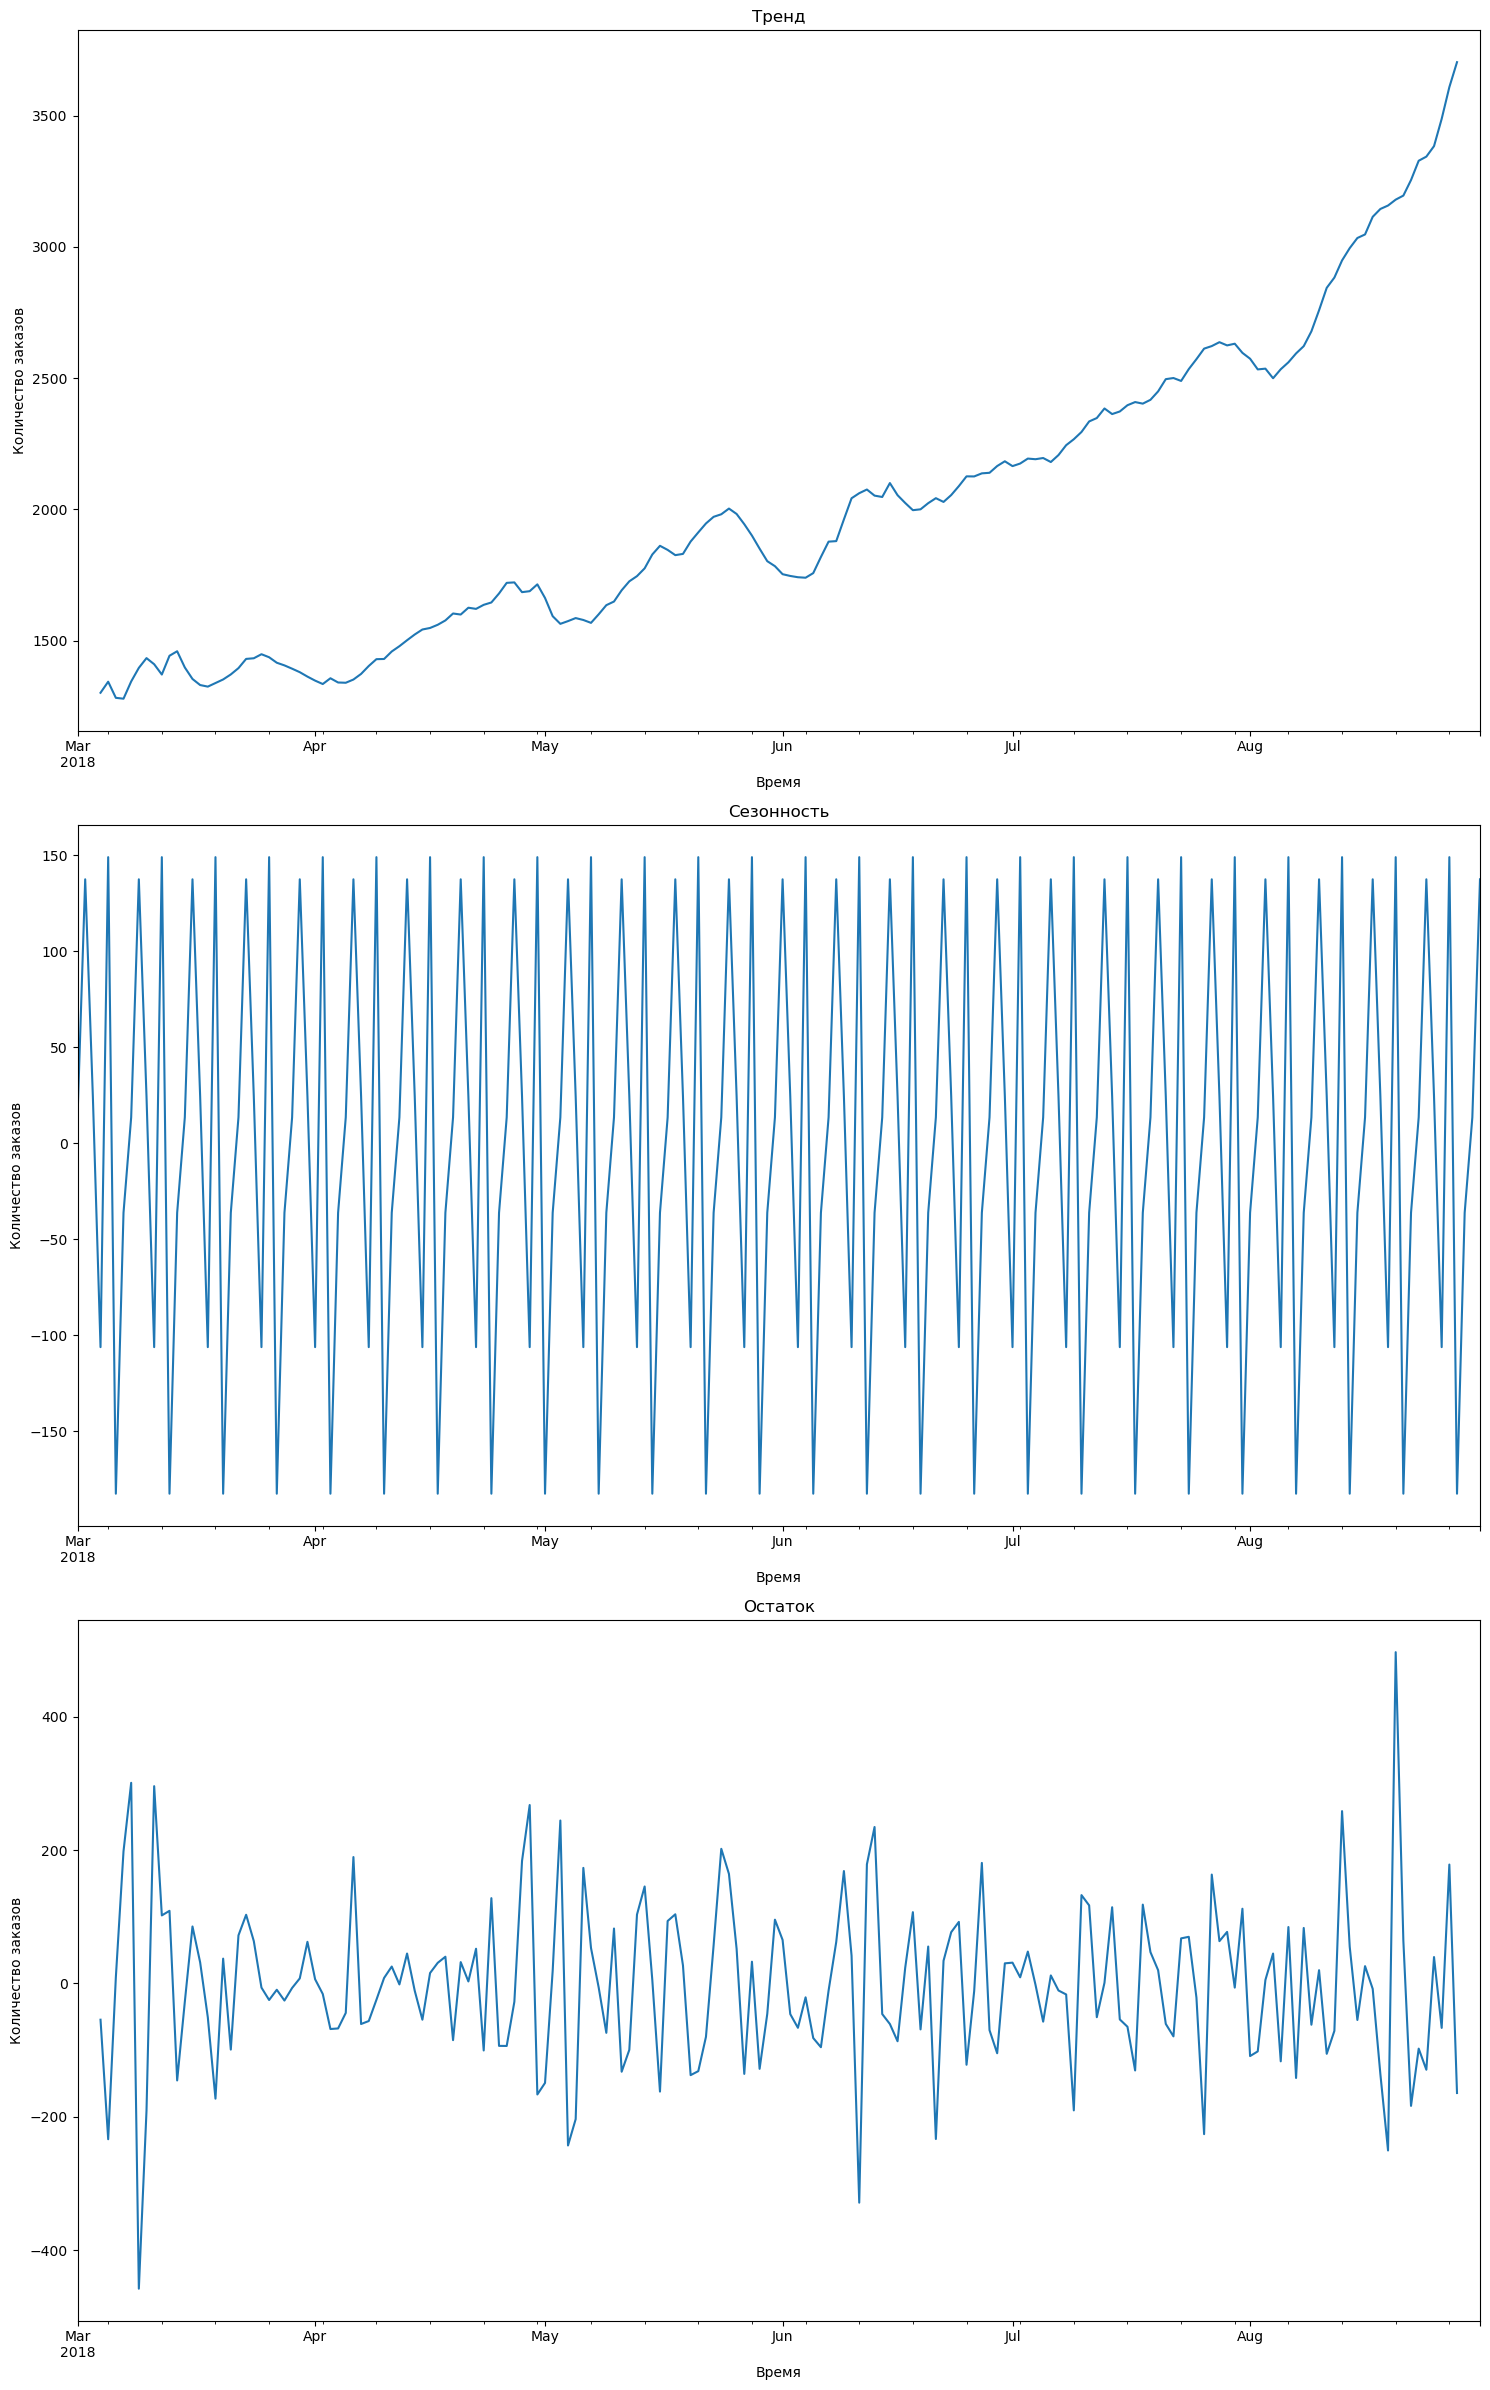

In [17]:
plt.figure(figsize=(15,24))
plt.subplot(311)
decomposed_daily.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed_daily.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed_daily.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.tight_layout()

Видим сезонность по неделям.

Рассмотрим подробнее данные за один полный месяц (март). Серым цветом на графиках отмечены выходные.

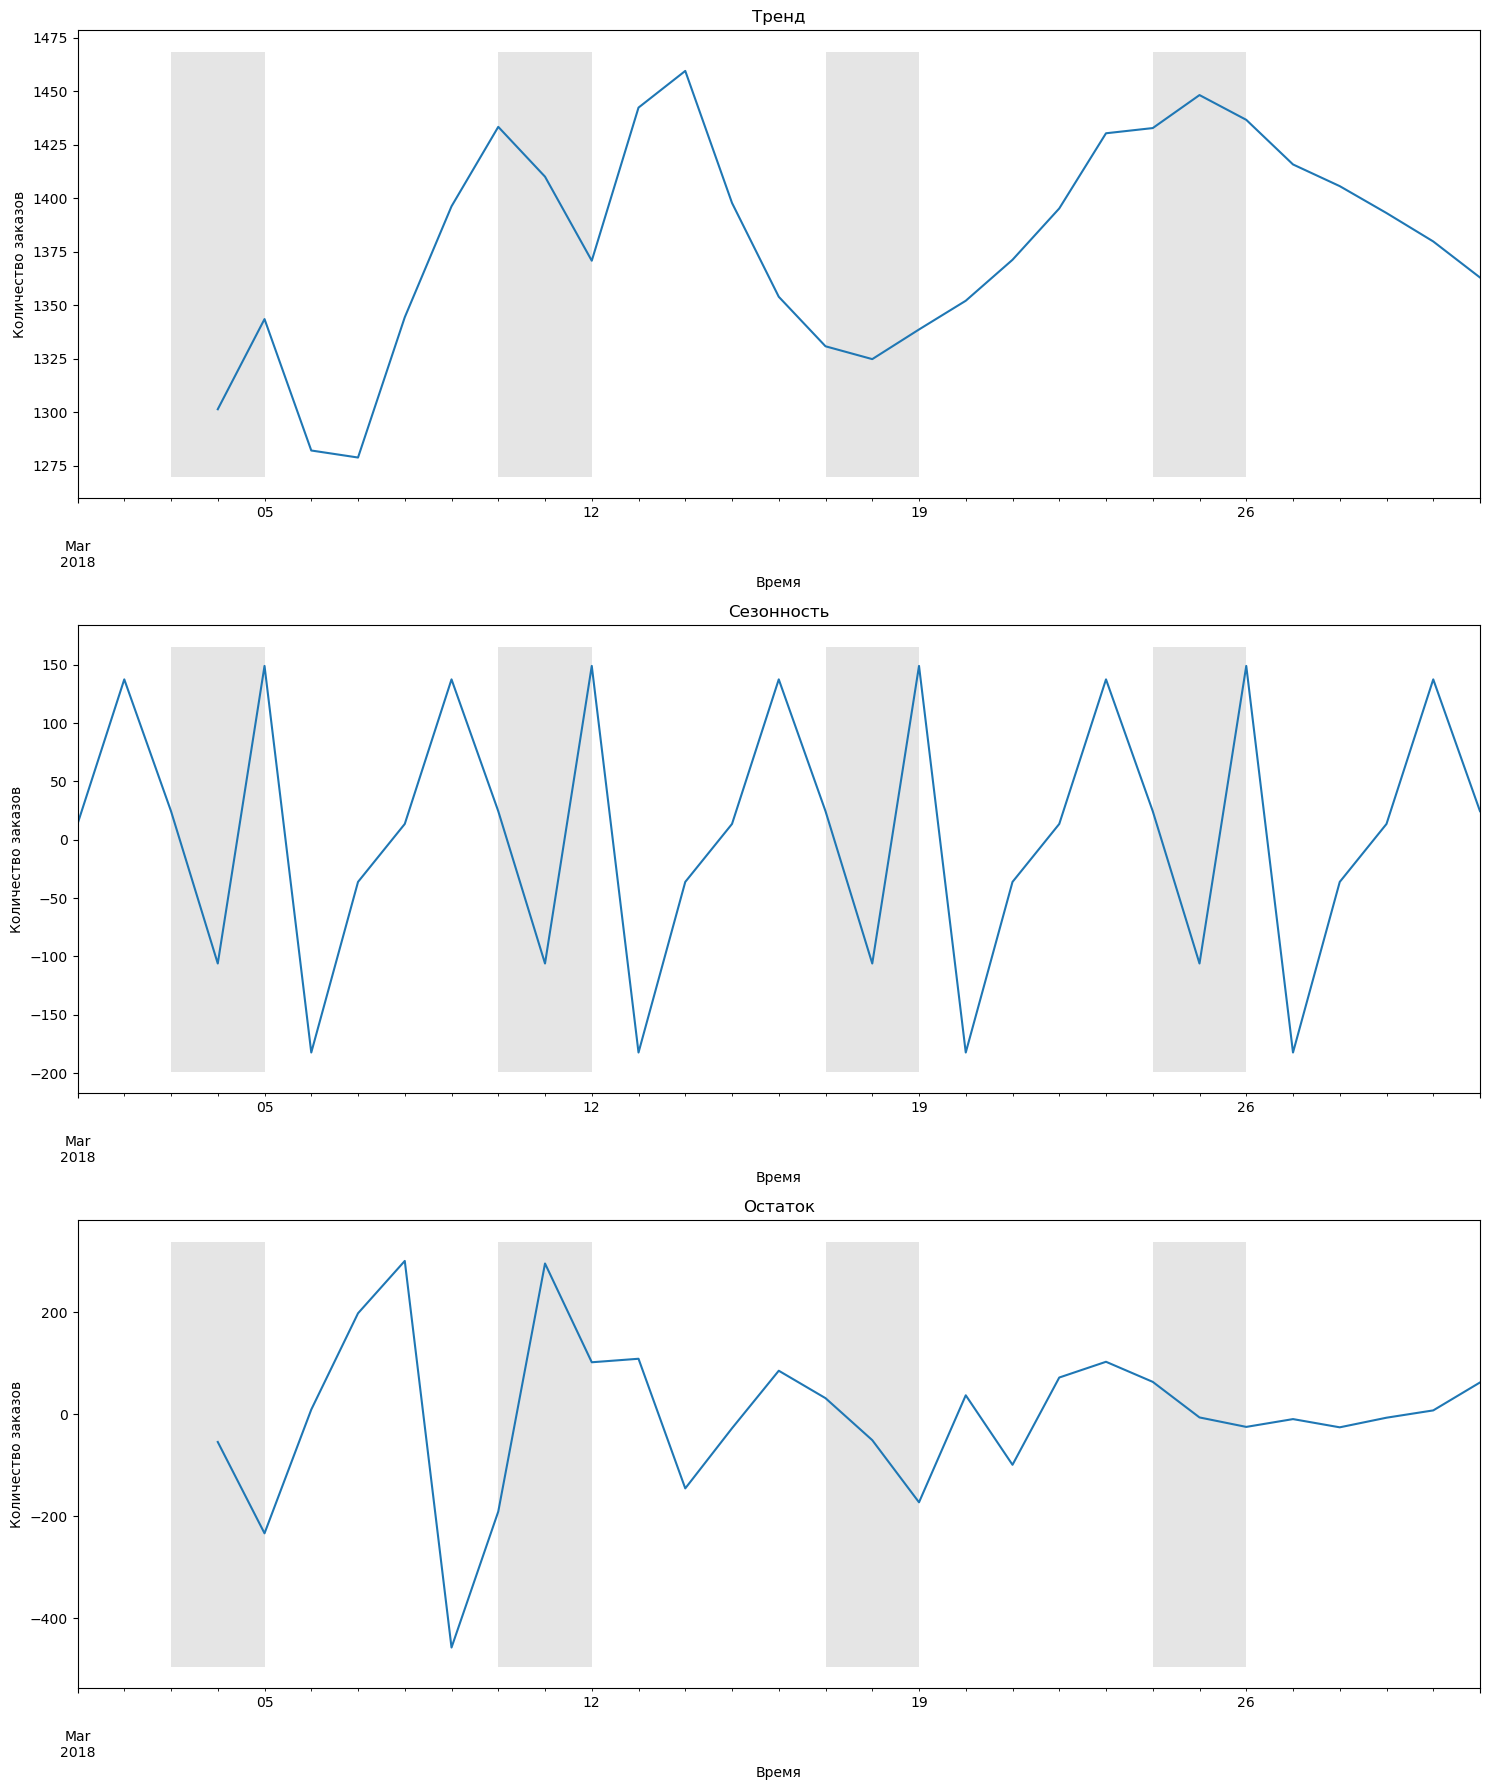

In [18]:
plt.figure(figsize=(15,18))

plt.subplot(311)
decomposed_daily.trend['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
xmin, xmax = plt.gca().get_xlim()
days = np.arange(np.floor(xmin), np.ceil(xmax)+2)
weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
plt.gca().fill_between(days, *plt.gca().get_ylim(), where=weekends, facecolor='k', alpha=.1)
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Количество заказов')

plt.subplot(312)
decomposed_daily.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.gca().fill_between(days, *plt.gca().get_ylim(), where=weekends, facecolor='k', alpha=.1)
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество заказов')

plt.subplot(313)
decomposed_daily.resid['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.gca().fill_between(days, *plt.gca().get_ylim(), where=weekends, facecolor='k', alpha=.1)
plt.title('Остаток')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.tight_layout()

Видим сезонность по неделям. Количество заказов снижается до минимума во вторник и растет в пятницу и понедельник. Вероятно, высокий спрос к концу недели связан с тем, что выходные - это удобное время для начала или окончания поездок, а низкий спрос во вторник – с тем, что этот день находится почти посередине рабочей недели и редко выбирается для путешествий.

Рассмотрим данные за неделю. Возьмем первую полную неделю марта.

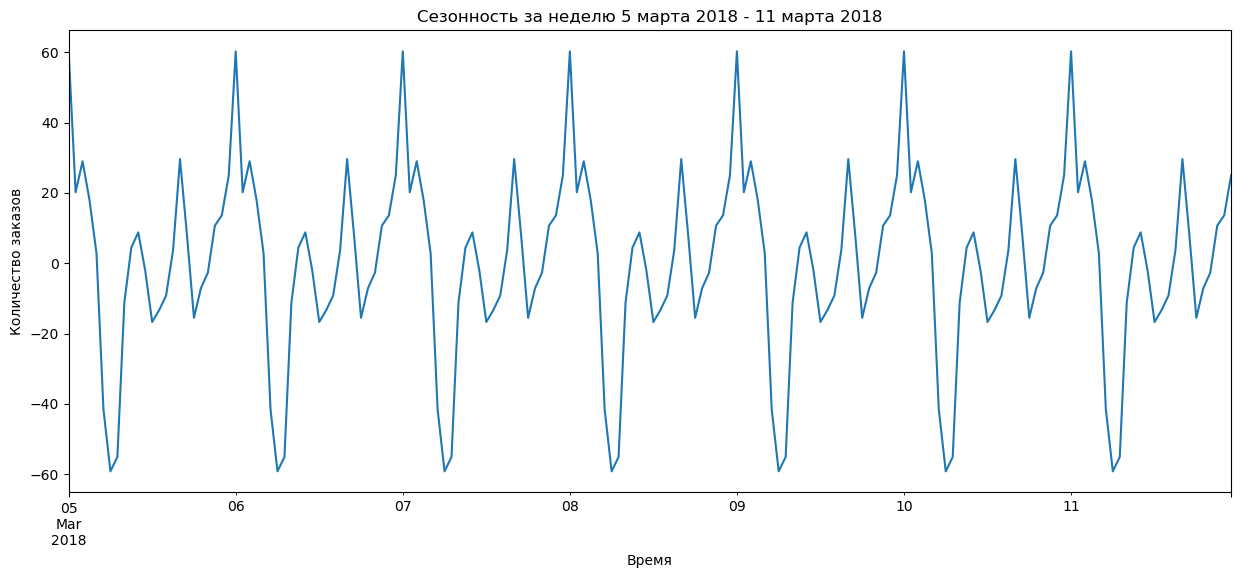

In [19]:
plt.figure(figsize=(15,6))
decomposed.seasonal['2018-03-05':'2018-03-11'].plot()
plt.title('Сезонность за неделю 5 марта 2018 - 11 марта 2018')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Видим сезонность по дням.

Рассмотрим данные за один день. Возьмем 1 марта.


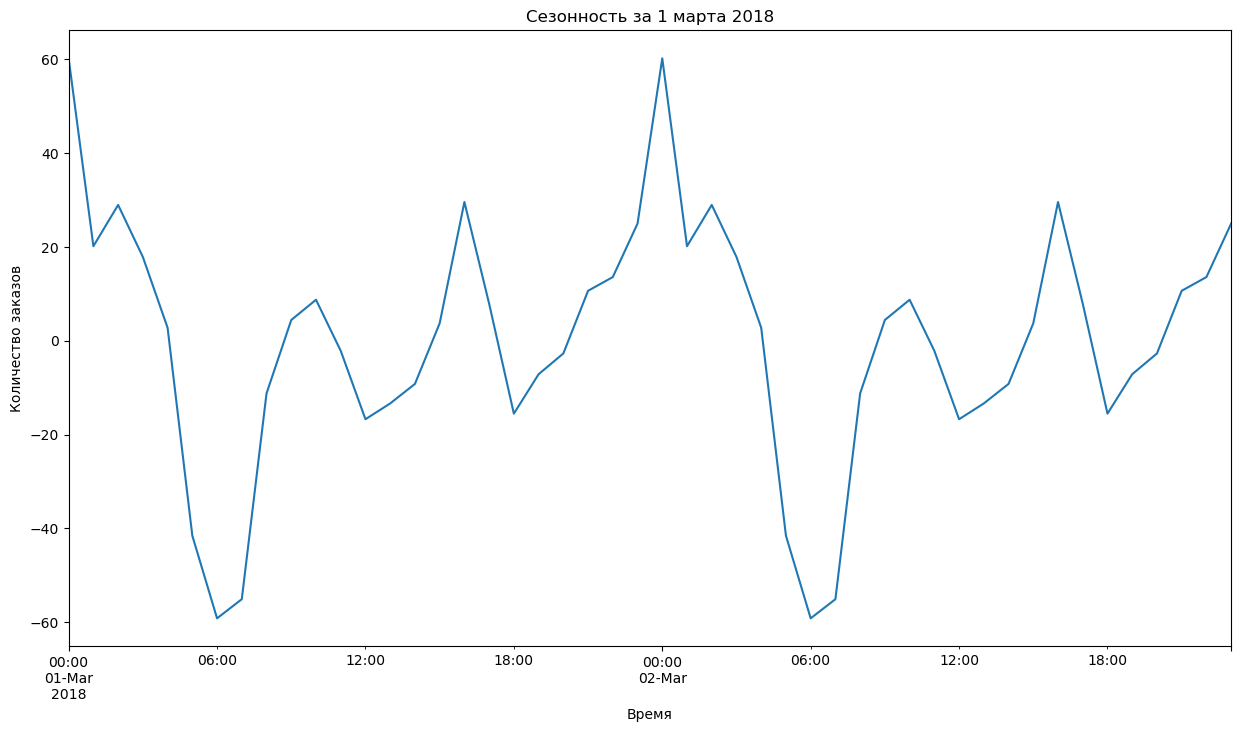

In [20]:
plt.figure(figsize=(15,8))
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()
plt.title('Сезонность за 1 марта 2018')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Видим пик количества заказов, приходящийся на полночь. К шести утра количество заказов снижается до минимума. Вероятно, связано с общественным транспортом - когда с утра начинает ходить общественный транспорт, необходимость в такси снижается, и наоборот.

### Анализ временного ряда - итог

Проанализировали временной ряд данных о количестве заказов такси. Имеются данные за полгода - с 1 марта 2018 по 31 августа 2018 включительно. В исходных данных интервал 10 минут, мы провели ресемплинг по 1 часу.
1. Временной ряд нестационарный, видим тренд на увеличение количества заказов со временем.
2. Разложили ряд на составляющие. Видим общий тренд увеличения числа заказов. Возможно, это тренд на увеличение популярности такси в целом, а возможно - сезонность, т.к. наибольшее количество заказов наблюдаем в августе, на пике сезона отпусков. Но т.к. данные у нас только за полгода, мы не можем сделать вывод о сезонности такого уровня.
    Также видим некоторую сезонность меньшего масштаба - по неделям или по дням. Далее рассмотрим ее подробнее.
    Остатки значительно увеличиваются, начиная с августа.
3. Анализ данных за месяц показал сезонность по неделям. Количество заказов снижается во вторник и растет в пятницу и понедельник. Вероятно, высокий спрос к концу недели связан с тем, что выходные - это удобное время для начала или окончания поездок, а низкий спрос во вторник – с тем, что этот день находится почти посередине рабочей недели и редко выбирается для путешествий.
4. Анализ данных за неделю также показал сезонность по дням. Видим пик количества заказов, приходящийся на полночь. К шести утра количество заказов снижается до минимума. Вероятно, связано с общественным транспортом - когда с утра начинает ходить общественный транспорт, необходимость в такси снижается, и наоборот.

## Обучение

### Вспомогательные функции

In [22]:
def make_features(df, max_lag, rolling_mean_size):
    '''Создает признаки для обучения модели прогнозирования.
    Получает на вход датафрейм, максимальный размер отставания и ширину окна.
    Создает календарные признаки month, day, dayofweek, 
    max_lag отстающих значений
    и скользящее среднее с размером окна rolling_mean_size.
    '''
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

### Подготовка выборки

Создадим дополнительные признаки.

In [23]:
data = make_features(data, 24, 168)

Разделим выборки на обучающую и тестовую. В качестве тестовой выборки берем последние 10 процентов нашего ряда.

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE)

Удалим из обучающей выборки строки с пропусками, вызванные отсутствием исторических данных для первых значений.

In [25]:
train.isna().sum().max()

168

В Train 168 строк с пропусками, т.к. мы выбрали размер окна для скользящего среднего величиной в неделю (168 часов).

In [26]:
train = train.dropna()

Проверим размерности.

In [27]:
data.shape, train.shape, test.shape, data.shape[0] - train.shape[0] - test.shape[0]

((4416, 29), (3806, 29), (442, 29), 168)

Выделим входные и целевой признаки.

In [28]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Еще раз проверим размерности.


In [29]:
data.shape, train_features.shape, train_target.shape, test_features.shape, test_target.shape

((4416, 29), (3806, 28), (3806,), (442, 28), (442,))

### Обучение моделей

#### Линейная регрессия

Создадим TimeSeriesSplit для кросс-валидации по временному ряду.

In [30]:
tscv = TimeSeriesSplit(n_splits=5)

Обучим модель линейной регрессии.

In [31]:
model_lr = LinearRegression()

In [32]:
scores_lr = cross_val_score(model_lr, train_features, train_target, scoring='neg_root_mean_squared_error', cv=tscv) 
scores_lr.mean()*(-1)

27.253854663285733

In [33]:
model_lr.fit(train_features, train_target)

LinearRegression()

Обучили линейную регрессию. RMSE на кросс-валидации: 27.25.

####  CatBoost

Подберем параметры для CatBoost, используя RandomizedSearchCV и полученный нами на предыдущем шаге TimeSeriesSplit.

In [34]:
params_cb = [
    {
        'iterations': [200, 500, 1000],
        'depth': range(1, 5)
    }
]

In [35]:
randomized_search_cb = RandomizedSearchCV(
    CatBoostRegressor(logging_level='Silent', allow_writing_files=False), 
    params_cb, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [36]:
randomized_search_cb.fit(train_features, train_target)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001FD3CD89B90>,
                   n_jobs=-1,
                   param_distributions=[{'depth': range(1, 5),
                                         'iterations': [200, 500, 1000]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [37]:
print('Параметры лучшей модели:\n', randomized_search_cb.best_params_)
print ('\nМетрика лучшей модели на кросс-валидации:', randomized_search_cb.best_score_*(-1))

Параметры лучшей модели:
 {'iterations': 1000, 'depth': 4}

Метрика лучшей модели на кросс-валидации: 25.43875115733072


### Обучение - итог

1. Подготовили выборку для обучения моделей. Добавили календарные признаки: месяц, день, день недели, 24 отстающих значения и скользящее среднее с размером окна в неделю (168 часов). Выборку разделили на train/test в соотношении 9:1.
2. Обучили модель линейной регрессии для прогнозирования количества заказов на следующий час. RMSE на кросс-валидации 27.25.
3. Обучили модель CatBoost для прогнозирования количества заказов на следующий час. Подобрали параметры, используя RandomSearchCV. Параметры лучшей модели: iterations=1000, depth=4. RMSE на кросс-валидации 25.44.

## Тестирование

### Проверка на тестовой выборке

Проверим обученные модели на тестовой выборке.

In [38]:
test_pred_lr = model_lr.predict(test_features)
rmse_lr = mean_squared_error(test_target, test_pred_lr, squared=False)
rmse_lr

45.227047515746584

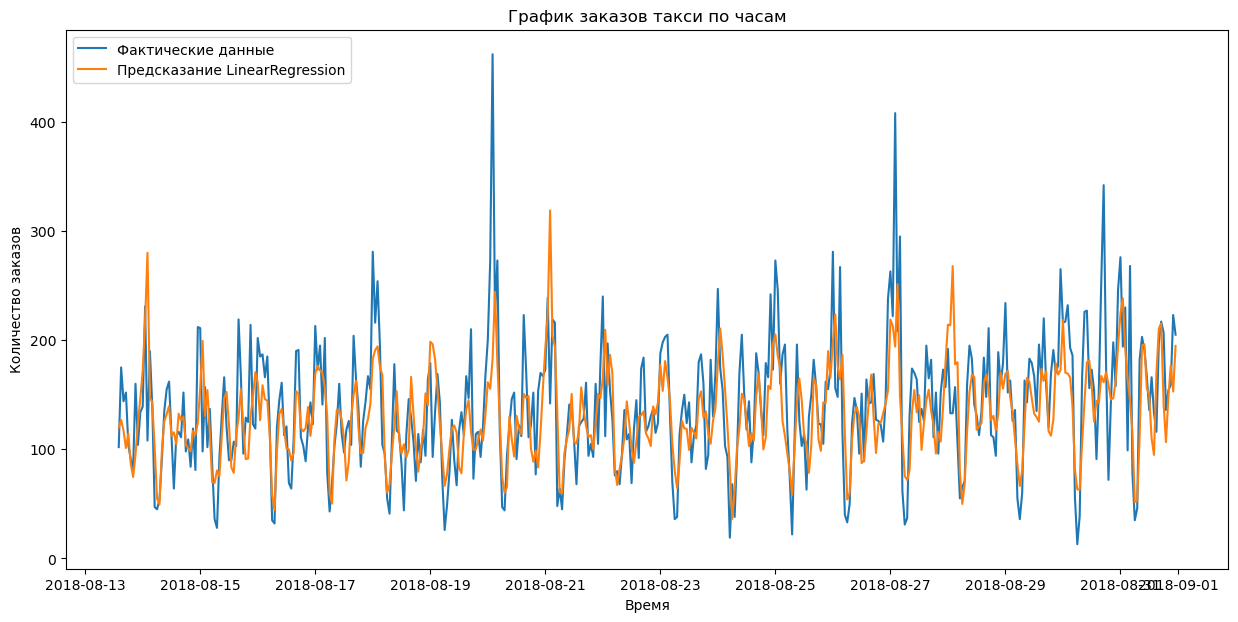

In [39]:
plt.figure(figsize=(15,7))
plt.plot(test_target.index, test_target, label='Фактические данные')
plt.plot(test_target.index, test_pred_lr, label='Предсказание LinearRegression')
plt.legend(title='', loc='upper left')
plt.title('График заказов такси по часам')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

In [40]:
test_pred_cb = randomized_search_cb.best_estimator_.predict(test_features)
rmse_cb = mean_squared_error(test_target, test_pred_cb, squared=False)
rmse_cb

41.96279811045217

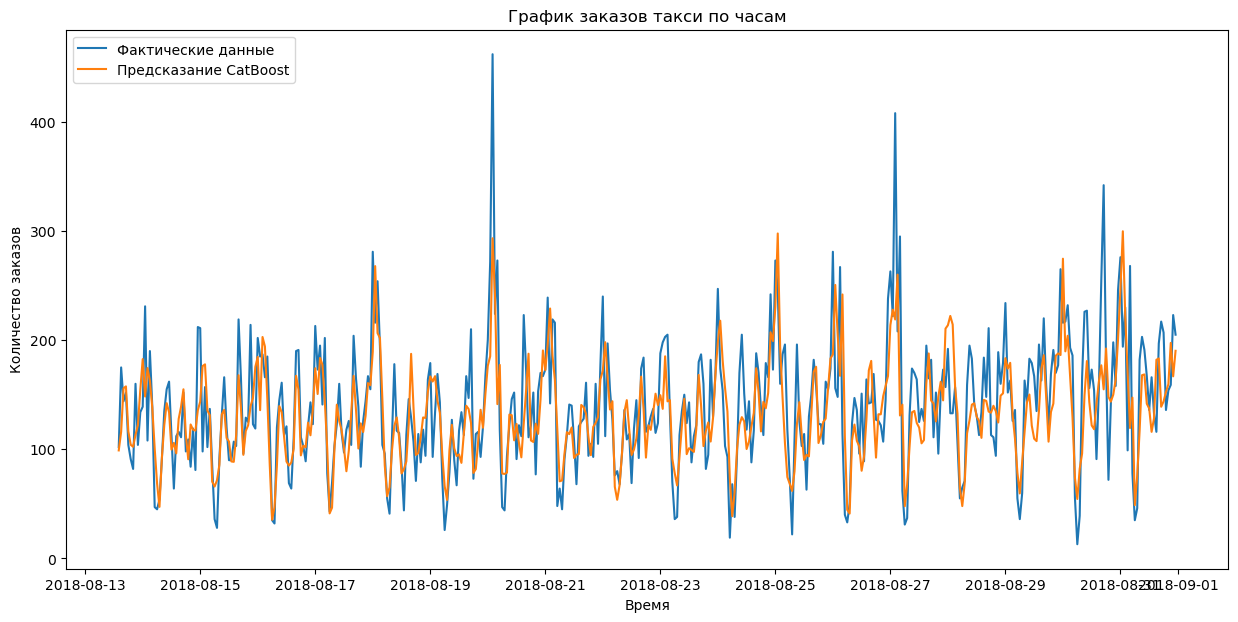

In [41]:
plt.figure(figsize=(15,7))
plt.plot(test_target.index, test_target, label='Фактические данные')
plt.plot(test_target.index, test_pred_cb, label='Предсказание CatBoost')
plt.legend(title='', loc='upper left')
plt.title('График заказов такси по часам')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

In [42]:
test_target.index.min(), test_target.index.max() 

(Timestamp('2018-08-13 14:00:00'), Timestamp('2018-08-31 23:00:00'))

Качество обеих моделей удовлетворяет требованию "RMSE на тестовой выборке должно быть не больше 48". 

При этом значения метрики значительно хуже, чем на кросс-валидации. Вероятно, это связано с тем, что мы наблюдали больше остатков (то есть непрогнозируемых случайных колебаний) в районе августа, и как раз этот период весь попал в тестовую выборку. На графиках видно, что модели хуже справились с предсказанием нестандартно высоких значений 13, 21 и 27 августа.

### Проверка на адекватность

Посчитаем RMSE для модели, всегда выдающей медиану.

In [43]:
pred_median = np.ones(test_target.shape) * train_target.median()

In [44]:
rmse_median = mean_squared_error(test_target, pred_median, squared=False)
rmse_median

86.41465855206327

Также посчитаем RMSE модели с прогнозом предыдущим значением ряда.

In [45]:
pred_previous = test_target.shift(fill_value=train_target.iloc[-1])

In [46]:
rmse_prev = mean_squared_error(test_target, pred_previous, squared=False)
rmse_prev

58.856486242815066

Сравним эти результаты с результатами обученных ранее моделей.

In [47]:
rmse_col = [rmse_lr, rmse_cb, rmse_median, rmse_prev]
results = {'RMSE': rmse_col}
results_table = pd.DataFrame(results, index=['LinearRegression', 'CatBoost', 
                                             'Предсказание медианой', 'Предсказание предыдущим значением'])
results_table.index.name = 'Модель'

In [48]:
(results_table
 .style
 .format({'RMSE': '{:.2f}'})
 .highlight_min(subset=['RMSE'], color='lightgreen')
 .apply(lambda row: ['background: salmon'] if (row['RMSE'] > RMSE_THRESHOLD) else [''], axis=1, subset=['RMSE'])
)

,RMSE
Модель,
LinearRegression,45.23
CatBoost,41.96
Предсказание медианой,86.41
Предсказание предыдущим значением,58.86


Качество обеих обученных моделей удовлетворяет условию RMSE ≤ 48. Лучшее качество на тестовой выборке у CatBoost - RMSE=41.96.

Обе модели прошли проверку на адекватность - они показывают качество лучше, чем предсказание константой или предыдущим значением.

### Тестирование - итог

Посчитали качество обученных моделей на тестовой выборке, а также провели проверку обученных моделей на адекватность.

1. Качество обеих обученных моделей удовлетворяет условию RMSE ≤ 48. Лучшее качество на тестовой выборке у CatBoost - RMSE=41.96.
    При этом значения метрики значительно хуже, чем на кросс-валидации. Вероятно, это связано с тем, что мы наблюдали больше остатков (то есть непрогнозируемых случайных колебаний) в районе августа, и как раз этот период весь попал в тестовую выборку. На графиках видно, что модели хуже справились с предсказанием нестандартно высоких значений 13, 21 и 27 августа.
2. Обе модели прошли проверку на адекватность - они показывают качество лучше, чем предсказание константой или предыдущим значением.

Сравнение RMSE моделей на тестовой выборке:
<table>
    <tr>
        <th>Модель</th>
        <th>RMSE</th> 
    </tr>
    <tr>
        <td>LinearRegression</td>
        <td>45.23</td>
    </tr>
     <tr>
        <td>CatBoost</td>
        <td><font color='green'>41.96</font></td>
    </tr>
    <tr>
        <td>Предсказание медианой</td>
        <td><font color='red'>86.41</font></td>
    </tr>
    <tr>
        <td>Предсказание предыдущим значением</td>
        <td><font color='red'>58.86</font></td>
    </tr>
    <tr>
</table>

## Общий вывод

Проанализировали данные о заказах такси в аэропортах, обучили модели для прогнозирования количества заказов такси на следующий час.
1. Проанализировали временной ряд данных о количестве заказов такси. Имеются данные за полгода - с 1 марта 2018 по 31 августа 2018 включительно. В исходных данных интервал 10 минут, мы провели ресемплинг по 1 часу.
    + Временной ряд нестационарный, видим тренд на увеличение количества заказов со временем.
    + Разложили ряд на составляющие. Видим общий тренд увеличения числа заказов. Возможно, это тренд на увеличение популярности такси в целом, а возможно - сезонность, т.к. наибольшее количество заказов наблюдаем в августе, на пике сезона отпусков. Но т.к. данные у нас только за полгода, мы не можем сделать вывод о сезонности такого уровня. Также видим некоторую сезонность меньшего масштаба - по неделям или по дням. Далее рассмотрим ее подробнее. Остатки значительно увеличиваются, начиная с августа.
    + Анализ данных за месяц показал сезонность по неделям. Количество заказов снижается во вторник и растет в пятницу и понедельник. Вероятно, высокий спрос к концу недели связан с тем, что выходные - это удобное время для начала или окончания поездок, а низкий спрос во вторник – с тем, что этот день находится почти посередине рабочей недели и редко выбирается для путешествий.
    + Анализ данных за неделю также показал сезонность по дням. Видим пик количества заказов, приходящийся на полночь. К шести утра количество заказов снижается до минимума. Вероятно, связано с общественным транспортом - когда с утра начинает ходить общественный транспорт, необходимость в такси снижается, и наоборот.
2. Подготовили выборку для обучения моделей. Добавили календарные признаки: месяц, день, день недели, 24 отстающих значения и скользящее среднее с размером окна в неделю (168 часов). Выборку разделили на train/test в соотношении 9:1.
    + Обучили модель линейной регрессии для прогнозирования количества заказов на следующий час. RMSE на кросс-валидации 27.25.
    + Обучили модель CatBoost для прогнозирования количества заказов на следующий час. Подобрали параметры, используя RandomSearchCV. Параметры лучшей модели: iterations=1000, depth=4. RMSE на кросс-валидации 25.44.
3. Посчитали качество обученных моделей на тестовой выборке, а также провели проверку обученных моделей на адекватность.
    + Качество обеих обученных моделей удовлетворяет условию RMSE ≤ 48. Лучшее качество на тестовой выборке у CatBoost - RMSE=41.96.
        При этом значения метрики значительно хуже, чем на кросс-валидации. Вероятно, это связано с тем, что мы наблюдали больше остатков (то есть непрогнозируемых случайных колебаний) в районе августа, и как раз этот период весь попал в тестовую выборку.
    + Обе модели прошли проверку на адекватность - они показывают качество лучше, чем предсказание константой или предыдущим значением.

    Сравнение RMSE моделей на тестовой выборке:
    <table>
        <tr>
            <th>Модель</th>
            <th>RMSE</th> 
        </tr>
        <tr>
            <td>LinearRegression</td>
            <td>45.23</td>
        </tr>
         <tr>
            <td>CatBoost</td>
            <td><font color='green'>41.96</font></td>
        </tr>
        <tr>
            <td>Предсказание медианой</td>
            <td><font color='red'>86.41</font></td>
        </tr>
        <tr>
            <td>Предсказание предыдущим значением</td>
            <td><font color='red'>58.86</font></td>
        </tr>
        <tr>
    </table>

[В начало](#title)